## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Tutorial 6: Incorporation of Temporal Uncertainty in Gaussian Process

When analyzing paleo environmental data, e.g., relative sea-level (RSL) records, it is important to consider the presence of uncertainties in both the reconstruction of RSL (vertical axis) and the chronology (horizontal axis) of the data. While it is relatively straightforward to incorporate output data uncertainty using variance-weighted Gaussian Process (GP) regression (i.e., adding vertical variance into the diagonal of covariance matrix), incorporating chronological uncertainties in GP regression is more challenging.

In this tutorial, we will demonstrate two commonly used methods for incorporating temporal uncertainty in paleo sea-level research. Specifically, we will cover:

**&#10148; 1.** Noisy-input Gaussian Process 

**&#10148; 2.** Errors-in-variable Gaussian Process 

**&#10148; 3.** Performance Comparison 

To demonstrate, let's start with loading the module and generating some synthetic noisy data from a sine wave:

In [1]:
#load modules
import os
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import sys
sys.path.append('../../Code')
import PSTHM 
import time
import seaborn as sns
from scipy import interpolate
smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(0) #set random seed used in this notebook

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

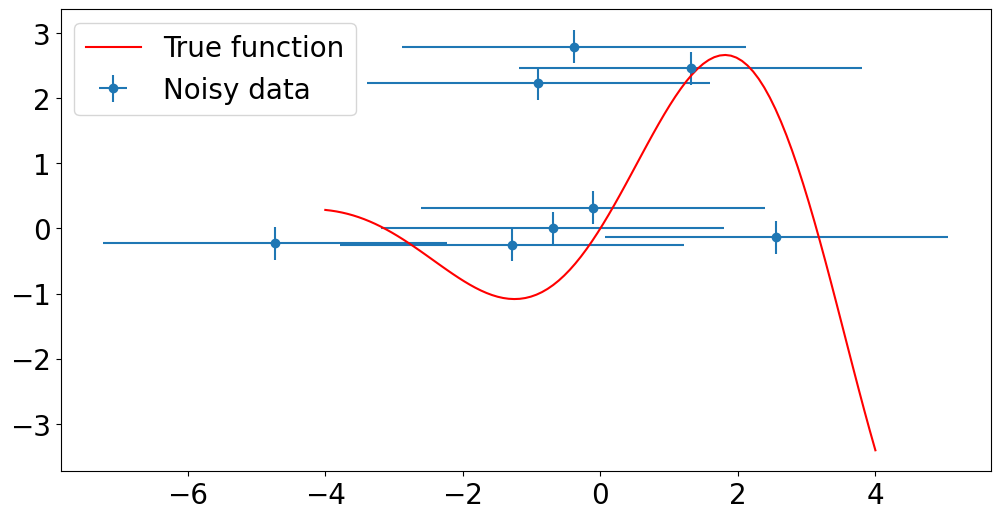

In [7]:
np.random.seed(123456)
x = torch.linspace(-3,3,100).double()[np.sort(np.random.randint(0,100,8))]
x_full = torch.linspace(-4,4,100).double()
def f(x):
    return 1.5*torch.sin(x)*torch.linspace(1,3,len(x)).double()*torch.linspace(0.5,1,len(x)).double()**2
y = f(x)

x_noise = 2.5
y_noise =0.25
x_noisy = x+np.random.normal(0,x_noise,len(x))
y_noisy = y+np.random.normal(0,y_noise,len(y))
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0',label='Noisy data')
plt.plot(x_full,f(x_full),color='r',label='True function')
plt.legend();

You can clearly see that our data is very noisy and provide really limited information on the right side of the function. Let's start with normal GP only considering the vertical uncertainty. You should be failry familiar with the code below, which is the same code we used for past several tutorials:

In [28]:
# Normal GP without considering x error
pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(1.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(x, y, RBF_kernel,noise=torch.ones(len(x))*y_noise**2,jitter=1e-5)

# #Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=1000)

print('Length Scale: ',track_list['lengthscale'].iloc[-1],'Variance: ',track_list['variance'].iloc[-1])

#cal mean and variance of GP
GP_mean, GP_var = gpr(x_full, full_cov=True,noiseless=True)
GP_sd = torch.diag(GP_var).sqrt()  # standard deviation at each input point x


  0%|          | 0/1000 [00:00<?, ?it/s]

Length Scale:  1.3607643841721786 Variance:  2.8537633191104153


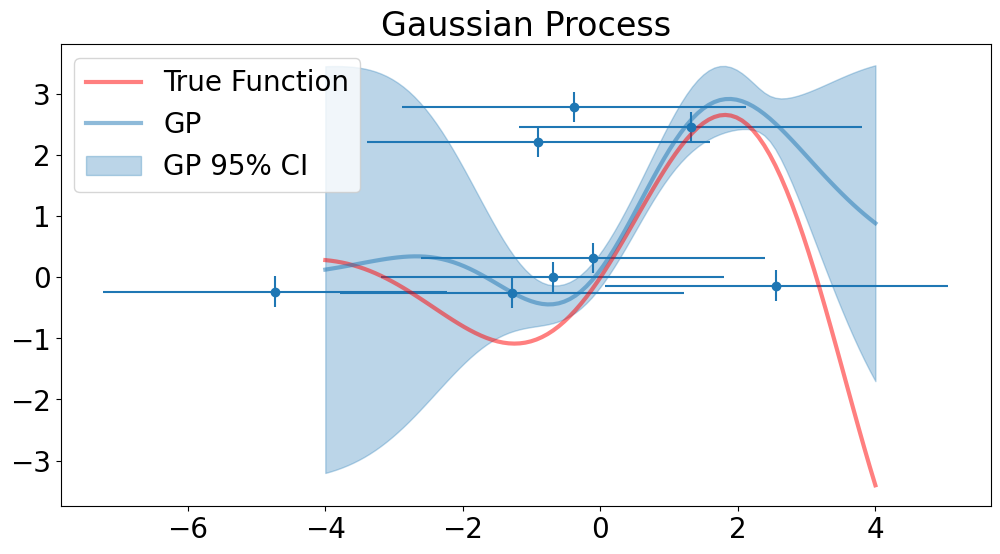

In [29]:
plt.title('Gaussian Process')
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='True Function',linewidth=3,alpha=0.5)
plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.legend();

Due to the significant uncertainties present in both the x and y axes of the data, the 95% credible interval (CI) obtained from normal Gaussian Process (GP) regression fails to accurately capture the true underlying function within the range between 0 and 2.5.

### 1. Noisy-Input Gaussian Process

Now, let's explore the noisy-input GP (NIGP) method. The NIGP method employs a first-order Taylor series approximation, which involves a linear expansion around each input point. This approximation enables the translation of errors in the temporal domain into equivalent errors in the relative sea-level (RSL) domain. Consequently, temporal uncertainty is transformed into RSL uncertainty, which is proportional to the squared gradient of the GP posterior mean.

Let's write it down. Recall in GP background tutorial that, the observation $y$ can be noisy:
$$
y_{i} = f(t_{i},x_{i}) + \epsilon_{i}
$$

where indicates vertical uncertainty for each data point. Additionally, we consider input variable $t$ to be noisy as well here:
$$
\overline{t}_{i} = t_{i} + \delta{i}
$$
where $\overline{t}_{i}$ is the central point estimate of the input variable (e.g., calibrated age from geochronology), $t_{i}$ is the true input variable (e.g., true age), which is unknown and unobserved, and $\delta_{i}$ is the uncertainty for input variable (e.g., chronological uncertainty). For GP, it is default to assume both $\epsilon$ and $\delta$ to be normally distributed. 

For GP framework, vertical uncertainty can be easily incorporated by changing $K^{-1}$ (details in section 3 of tutorial 4) to:
$$
\hat{K}^{-1} = (K+\sigma_{\epsilon}^2 I)^{-1}
$$
where $I$ is an identity matrix and $\sigma_{\epsilon}$ indicates one-sigma observational uncertainty for each data point. To implement NIGP, we need to estimate the gradient of GP posterior mean relative to input variable: $\partial f = \frac{\partial f}{\partial t}$. It can then be used to transform temporal uncertainty into RSL uncertainty, and therefore, the covariance matrix is:
$$
\hat{K}^{-1}_{NIGP} = (K+\sigma_{epsilon}^2 I +\sigma_{\delta}^2\partial f^{2}I )^{-1}
$$
where $\sigma_{\delta}$ is one-sigma uncertainty for input variable. 

To implement the NIGP method, we use an iterative method, which calculate $\frac{\partial f}{\partial t}$ for every iteration of optimization. To do this in PaleoSTeHM framework is very easy, you just change the optimization function from `SVI_optm` to `SVI_NI_optm`, which requires an extra input of horizontal uncertainty. 

In [31]:

pyro.clear_param_store()

#generate a RBF kernel 
NI_RBF_kernel = gp.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(1.))

#generate a GP gression model conditioned on RSL data
NI_gpr = PSTHM.GPRegression_V(x, y, RBF_kernel,noise=torch.ones(len(x))*y_noise**2,jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
NI_gpr,track_list = PSTHM.opti.SVI_NI_optm(NI_gpr,torch.tensor(x_noise),num_iteration=1000)
print('Length Scale: ',track_list['lengthscale'].iloc[-1],'Variance: ',track_list['variance'].iloc[-1])

#cal mean and variance of GP
NIGP_mean, NIGP_var = NI_gpr(x_full, full_cov=True,noiseless=True)
NIGP_sd = torch.diag(NIGP_var).sqrt()  # standard deviation at each input point x

  0%|          | 0/1000 [00:00<?, ?it/s]

Length Scale:  1.9509398384826127 Variance:  3.441209704458819


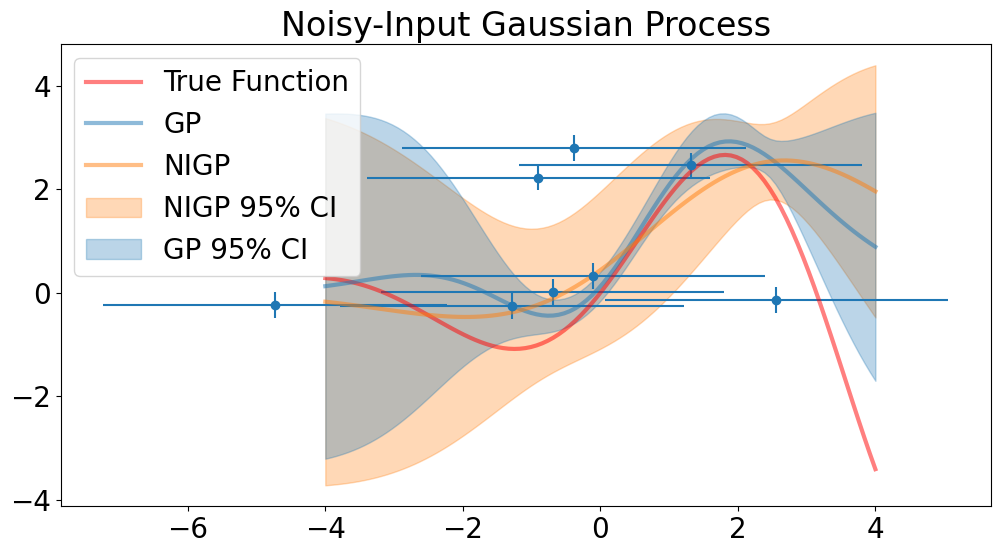

In [32]:
plt.title('Noisy-Input Gaussian Process')

plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='True Function',linewidth=3,alpha=0.5)
plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)

plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')
plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.legend();

Upon incorporating information about chronological errors, the 95% credible interval (CI) obtained through the noisy-input Gaussian Process (NI-GP) method exhibits an improvement, demonstrating a more reasonable behavior when dealing with the noisy data. Notably, the 95% CI successfully captures the true underlying function across a larger range. It should be noted that, given the same hyperparameters, considering chronological uncertainty using NI-GP will always results in larger 95% CI. 

### 2. Errors-In-Variable Gaussian Process

Another approach to address temporal uncertainty is by directly sampling temporal uncertainty using the errors-in-variable (EIV) framework through the utilization of the Markov Chain Monte Carlo (MCMC) algorithm, which enables a Fully Bayesian Analysis. This can be done by calculating covariance matrix with input uncertainty.

It is important to note that specifying the prior distribution is crucial in the Fully Bayesian Analysis as it directly impacts the prediction results. Considering the data and Empirical Bayes results, here I select a uniform prior distribution ranging from 0 to 6 for the length scale and from 0 to 20 for the variance. To implement EIV-GP in PaleoSTeHM, we change the GP model from `GPRegression_V` to `GPRegression_EIV` and fill this new model to MCMC sampler as before.

In [100]:
from pyro.contrib.gp.models.model import GPModel
from pyro.nn.module import PyroParam, pyro_method,PyroSample
from pyro.contrib.gp.util import conditional

class GPRegression_EIV(GPModel):
    r"""
    Gaussian Process Regression model.

    The core of a Gaussian Process is a covariance function :math:`k` which governs
    the similarity between input points. Given :math:`k`, we can establish a
    distribution over functions :math:`f` by a multivarite normal distribution

    .. math:: p(f(X)) = \mathcal{N}(0, k(X, X)),

    where :math:`X` is any set of input points and :math:`k(X, X)` is a covariance
    matrix whose entries are outputs :math:`k(x, z)` of :math:`k` over input pairs
    :math:`(x, z)`. This distribution is usually denoted by

    .. math:: f \sim \mathcal{GP}(0, k).

    .. note:: Generally, beside a covariance matrix :math:`k`, a Gaussian Process can
        also be specified by a mean function :math:`m` (which is a zero-value function
        by default). In that case, its distribution will be

        .. math:: p(f(X)) = \mathcal{N}(m(X), k(X, X)).

    Given inputs :math:`X` and their noisy observations :math:`y`, the Gaussian Process
    Regression model takes the form

    .. math::
        f &\sim \mathcal{GP}(0, k(X, X)),\\
        y & \sim f + \epsilon,

    where :math:`\epsilon` is Gaussian noise.

    .. note:: This model has :math:`\mathcal{O}(N^3)` complexity for training,
        :math:`\mathcal{O}(N^3)` complexity for testing. Here, :math:`N` is the number
        of train inputs.

    Reference:

    [1] `Gaussian Processes for Machine Learning`,
    Carl E. Rasmussen, Christopher K. I. Williams

    :param torch.Tensor X: A input data for training. Its first dimension is the number
        of data points.
    :param torch.Tensor y: An output data for training. Its last dimension is the
        number of data points.
    :param ~pyro.contrib.gp.kernels.kernel.Kernel kernel: A Pyro kernel object, which
        is the covariance function :math:`k`.
    :param torch.Tensor noise: Variance of Gaussian noise of this model.
    :param callable mean_function: An optional mean function :math:`m` of this Gaussian
        process. By default, we use zero mean.
    :param float jitter: A small positive term which is added into the diagonal part of
        a covariance matrix to help stablize its Cholesky decomposition.
    """

    def __init__(self, X, y, xerr,kernel, noise=None,mean_function=None, jitter=1e-6):
        assert isinstance(
            X, torch.Tensor
        ), "X needs to be a torch Tensor instead of a {}".format(type(X))
        if y is not None:
            assert isinstance(
                y, torch.Tensor
            ), "y needs to be a torch Tensor instead of a {}".format(type(y))
        
        super().__init__(X, y,kernel, mean_function, jitter)
        
        if len(torch.tensor(xerr).shape)==0:
            xerr = torch.ones(len(X))*xerr
        self.xerr = xerr.double()
        self = self.double() #GP in pyro should use double precision
        self.X = self.X.double()
        self.y = self.y.double()
        
        if noise is None:
            self.noise = PyroParam(noise, constraints.positive)
        else:
            self.noise = noise.double()
            
    @pyro_method
    def model(self):
        self.set_mode("model")
        N = self.X.size(0)
        self.x_noise = pyro.sample('x',dist.Normal(self.X,self.xerr**0.5).to_event(1),
                             obs=self.y)
        if self.X.dim()<=1:
            X_noisy = (self.x_noise)
        # else:
        #     X_noisy = self.X
        #     X_noisy[:,0] += self.x_noise

        Kff = self.kernel(X_noisy)
        Kff.view(-1)[:: N + 1] += self.jitter + self.noise  # add noise to diagonal
        Lff = torch.linalg.cholesky(Kff)
        zero_loc = X_noisy.new_zeros(X_noisy.size(0))
        f_loc = zero_loc + self.mean_function(X_noisy)
        if self.y is None:
            f_var = Lff.pow(2).sum(dim=-1)
            return f_loc, f_var
        else:

            return pyro.sample(
                self._pyro_get_fullname("y"),
                dist.MultivariateNormal(f_loc, scale_tril=Lff)
                .expand_by(self.y.shape[:-1])
                .to_event(self.y.dim() - 1),
                obs=self.y,
            )

    @pyro_method
    def guide(self):
        self.set_mode("guide")
        self._load_pyro_samples()

    def forward(self, Xnew, full_cov=False, noiseless=True):
        r"""
        Computes the mean and covariance matrix (or variance) of Gaussian Process
        posterior on a test input data :math:`X_{new}`:

        .. math:: p(f^* \mid X_{new}, X, y, k, \epsilon) = \mathcal{N}(loc, cov).

        .. note:: The noise parameter ``noise`` (:math:`\epsilon`) together with
            kernel's parameters have been learned from a training procedure (MCMC or
            SVI).

        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``self.X.shape[1:]``.
        :param bool full_cov: A flag to decide if we want to predict full covariance
            matrix or just variance.
        :param bool noiseless: A flag to decide if we want to include noise in the
            prediction output or not.
        :returns: loc and covariance matrix (or variance) of :math:`p(f^*(X_{new}))`
        :rtype: tuple(torch.Tensor, torch.Tensor)
        """
        self._check_Xnew_shape(Xnew)
        self.set_mode("guide")

        N = self.X.size(0)
        Kff = self.kernel(self.X+self.x_noise).contiguous()
        Kff.view(-1)[:: N + 1] += self.jitter + self.noise  # add noise to the diagonal
        Lff = torch.linalg.cholesky(Kff)

        y_residual = self.y - self.mean_function(self.X+self.x_noise)
        loc, cov = conditional(
            Xnew,
            self.X+self.x_noise,
            self.kernel,
            y_residual,
            None,
            Lff,
            full_cov,
            jitter=self.jitter,
        )

        if full_cov and not noiseless:
            M = Xnew.size(0)
            cov = cov.contiguous()
            cov.view(-1, M * M)[:, :: M + 1] += self.noise  # add noise to the diagonal
        if not full_cov and not noiseless:
            cov = cov + self.noise.abs()

        return loc + self.mean_function(Xnew), cov


In [184]:
posterior_y = np.zeros([1500,len(x_full)])
testing_x = dist.Normal(x,x_noise)
testing_y = dist.Normal(y,y_noise)
for i in range(1500):
    gpr.y = testing_y.sample()
    gpr.X = testing_x.sample()
    gpr.kernel.lengthscale = mcmc.get_samples()['kernel.lengthscale'][i]
    gpr.kernel.variance = mcmc.get_samples()['kernel.variance'][i]
    posterior_y[i] = gpr(x_full)[0].detach().numpy()
posterior_mean = posterior_y.mean(axis=0)
posterior_sd = posterior_y.std(axis=0) 

<ErrorbarContainer object of 3 artists>

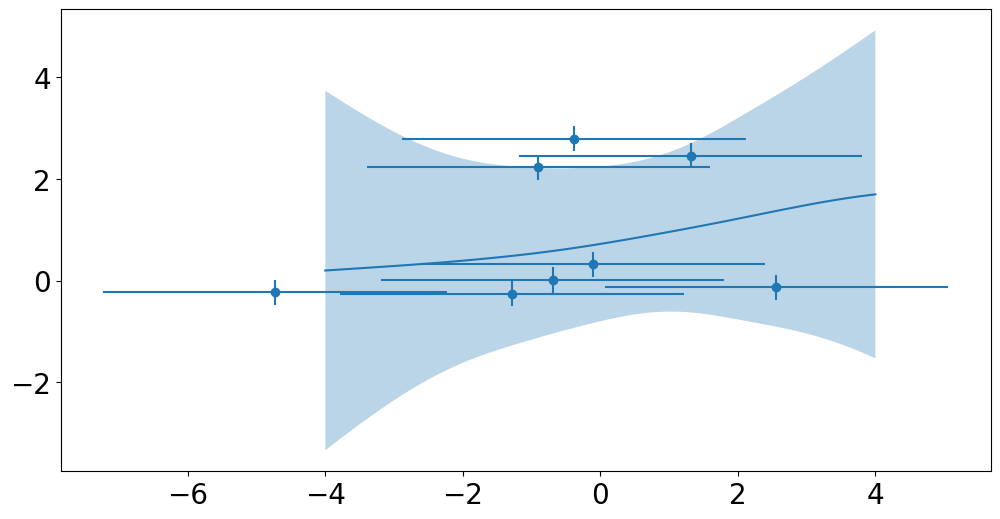

In [185]:
plt.plot(x_full,posterior_mean)
plt.fill_between(x_full,posterior_mean-2*posterior_sd,posterior_mean+2*posterior_sd,alpha=0.3)
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')


In [102]:
# EIV-GP method

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1)
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-3), torch.tensor(20.)))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1e-3), torch.tensor(6.)))

#generate a GP gression model conditioned on RSL data
EIV_gpr = GPRegression_EIV(x, y, x_noise**2,RBF_kernel,noise=torch.tensor(y_noise**2),jitter=1e-5)

#use NUTS mcmc to sample the posterior distribution of hyperparameters
#if this is too low, slightly decrease the target_accept_prob and restart again!
mcmc = PSTHM.opti.NUTS_mcmc(EIV_gpr,num_samples=1500,warmup_steps=200)

#predict the mean and variance of GP
EIVGP_mean,EIVGP_cov,EIVGP_sd,likelihood_list = mcmc_predict(EIV_gpr,mcmc,x_full)

Sample: 100%|██████████| 1700/1700 [00:16, 104.35it/s, step size=7.76e-01, acc. prob=0.896]


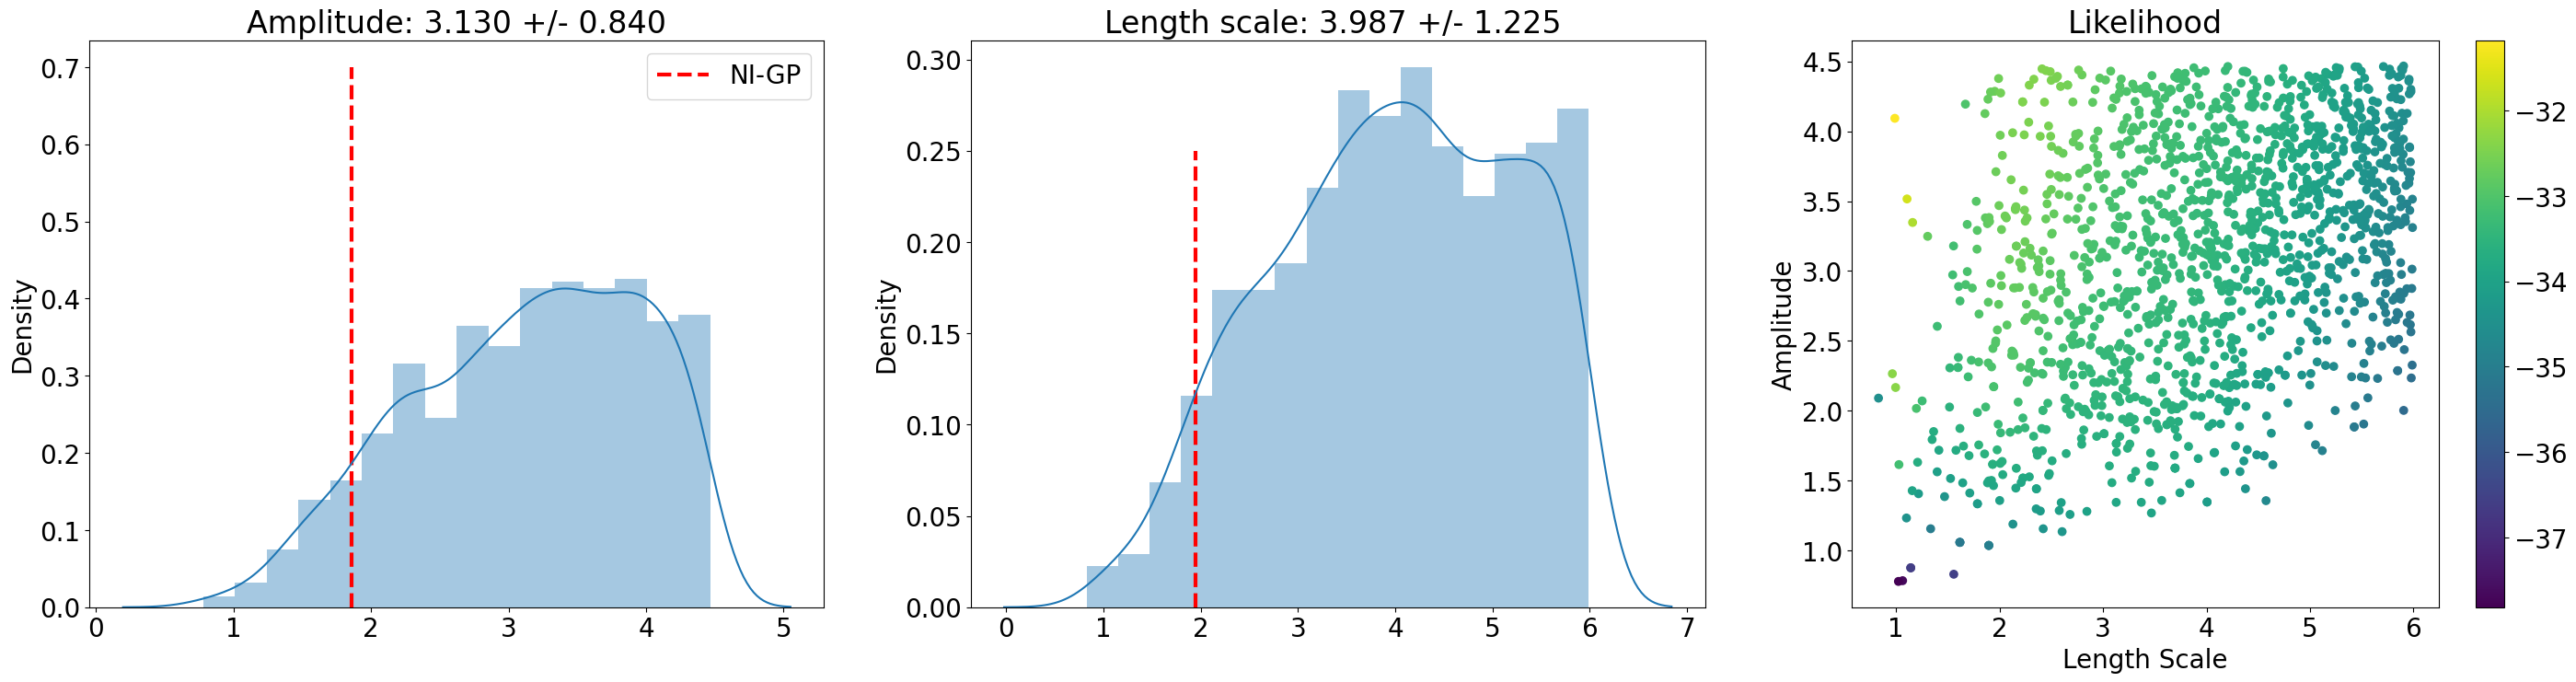

In [164]:
mcmc_variance =mcmc.get_samples()['kernel.variance']
mcmc_lengthscale = mcmc.get_samples()['kernel.lengthscale']

plt.figure(figsize=(35,8))
plt.subplot(131)
sns.distplot(mcmc_variance**0.5)
plt.vlines(NI_gpr.kernel.variance.item()**0.5,0,0.7,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Amplitude: {:5.3f} +/- {:5.3f}'.format(torch.mean(mcmc_variance**0.5),
                                            torch.std(mcmc_variance**0.5)))
plt.legend()
plt.subplot(132)
sns.distplot(mcmc_lengthscale)
plt.vlines(NI_gpr.kernel.lengthscale.item(),0,0.25,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Length scale: {:5.3f} +/- {:5.3f} '.format(torch.mean(mcmc_lengthscale),
                                                           torch.std(mcmc_lengthscale)))

plt.subplot(133)
plt.title('Likelihood')

plt.scatter(mcmc_lengthscale,mcmc_variance**0.5,c=likelihood_list)
plt.colorbar()
plt.xlabel('Length Scale')
plt.ylabel('Amplitude');

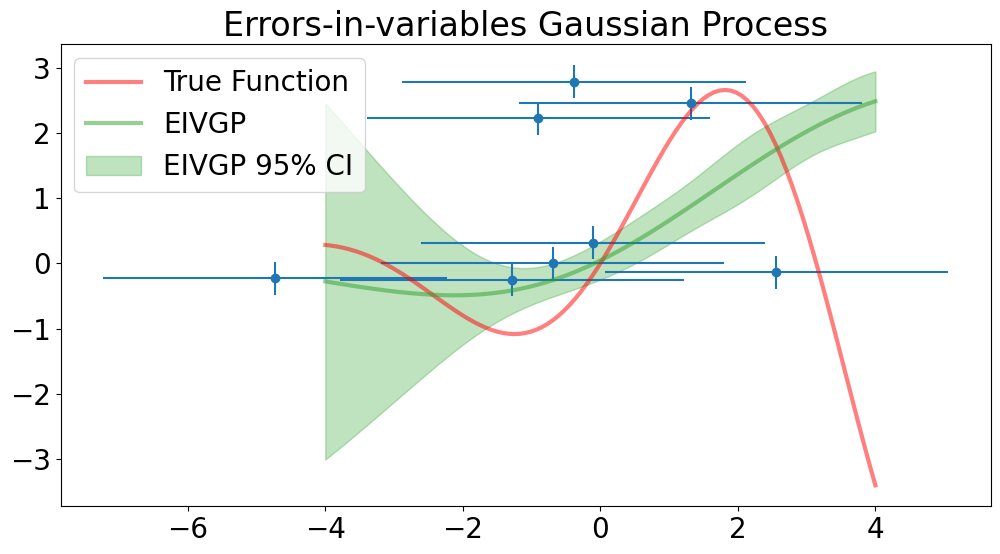

In [107]:
plt.title('Errors-in-variables Gaussian Process')
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')
plt.plot(x_full,f(x_full),color='r',label='True Function',linewidth=3,alpha=0.5)
plt.plot(x_full,EIVGP_mean,color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,EIVGP_mean-2*EIVGP_sd,EIVGP_mean+2*EIVGP_sd,alpha=0.3,color='C2',label='EIVGP 95% CI')
plt.legend();



It is quite evident that the 95% CI obtained through the Errors-in-Variable Gaussian Process (EIV-GP) method exhibits a more structured behavior compared to the Noisy-Input GP (NI-GP) method. This improved structure is a result of directly sampling the x errors using the MCMC algorithm within the EIV-GP framework. Like NI-GP, the 95% CI derived from the EIV-GP method captures the true underlying function over a good area.

### 3. Performance Comparison 

Now, let's compare and visualize the outcomes of the three different methods by plotting them together for a comprehensive evaluation.

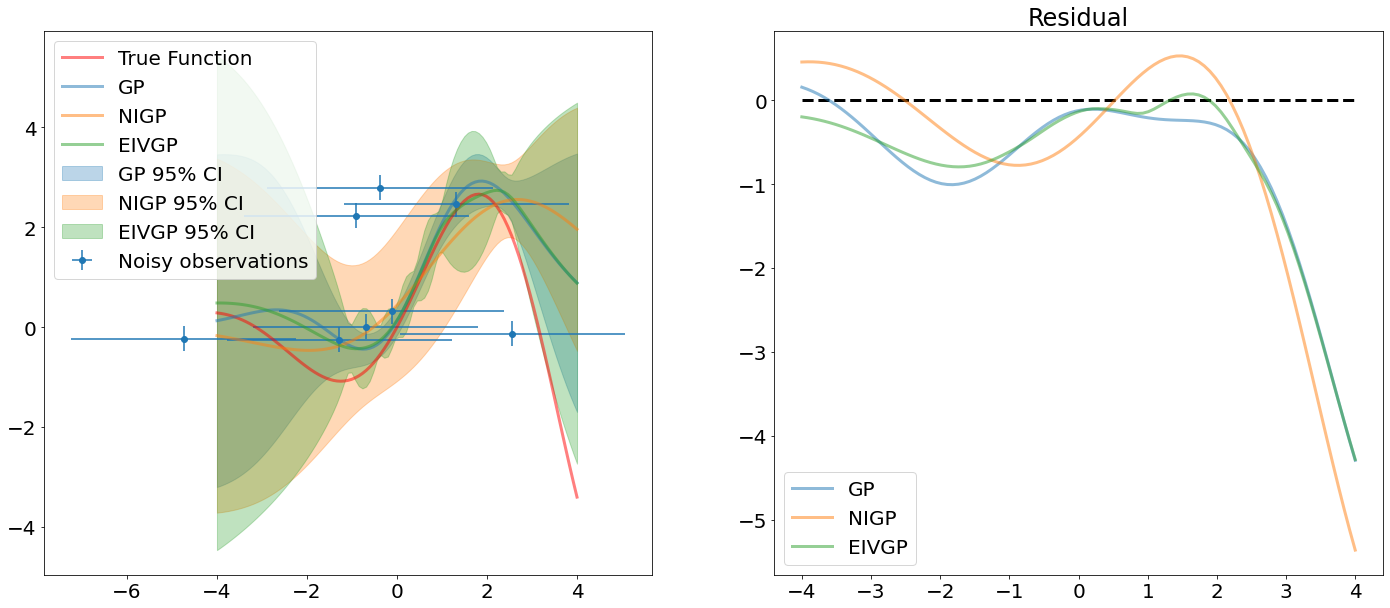

In [17]:
plt.figure(figsize=(24,10))
plt.subplot(121)
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0',label='Noisy observations')

plt.plot(x_full,f(x_full),color='r',label='True Function',linewidth=3,alpha=0.5)
plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(x_full,EIVGP_mean,color='C2',label='EIVGP',linewidth=3,alpha=0.5)

plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')
plt.fill_between(x_full,EIVGP_mean-2*EIVGP_sd,EIVGP_mean+2*EIVGP_sd,alpha=0.3,color='C2',label='EIVGP 95% CI')

plt.legend()

plt.subplot(122)
plt.plot(x_full,f(x_full)-GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-EIVGP_mean,color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.hlines(0,-4,4,linewidth=3,linestyles='--',color='k')
plt.title('Residual')
plt.legend();

#### Test with alternative data

You might find the regression results aren't satisfying enough. But given the really noisy data and limited data amount, GPs actually already do a fairly good job. This unsatisfactory results can be easily improved by slight increase the data amount and less observational uncertainty, let's try to generate some new data with slightly more observation data with lower observational uncertainty from a different sine wave function. 

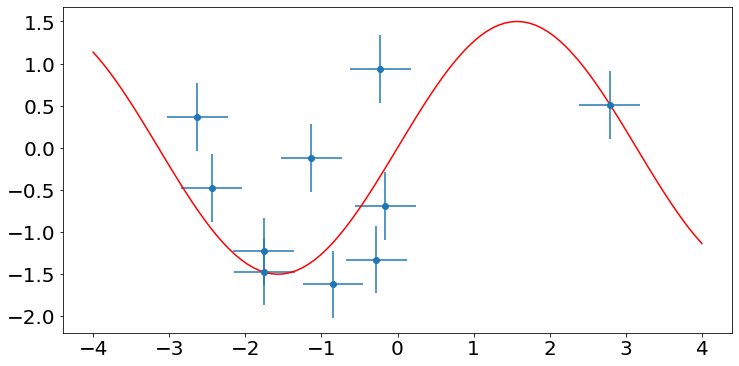

In [21]:
np.random.seed(12345)
x = torch.linspace(-3,3,100).double()[np.sort(np.random.randint(0,100,10))]
x_full = torch.linspace(-4,4,100).double()
def f(x):
    return 0+ 1.5*torch.sin(x)
y = f(x)

x_noise = 0.4
y_noise =0.4
x_noisy = x+np.random.normal(0,x_noise,len(x))
y_noisy = y+np.random.normal(0,y_noise,len(y))
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')
plt.plot(x_full,f(x_full),color='r');

You can see that the observational data still looks quite confusing, let's see how different GPs recovery the true function!

In [22]:
# Normal GP without considering x error
pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(1.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(x, y, RBF_kernel,noise=torch.tensor(y_noise**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_optm(gpr,num_iteration=1000)

print('Length Scale: ',track_list['lengthscale'].iloc[-1],'Variance: ',track_list['variance'].iloc[-1])

#cal mean and variance of GP
GP_mean, GP_var = gpr(x_full, full_cov=True,noiseless=True)
GP_sd = torch.diag(GP_var).sqrt()  # standard deviation at each input point x


  0%|          | 0/1000 [00:00<?, ?it/s]

Length Scale:  1.1336709885301133 Variance:  0.7016392431142243


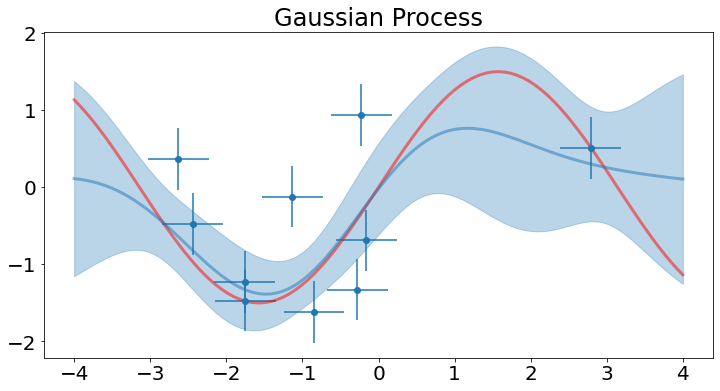

In [23]:
plt.title('Gaussian Process')
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='Ground Truth',linewidth=3,alpha=0.5)
plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI');

In [24]:

pyro.clear_param_store()

#generate a RBF kernel 
NI_RBF_kernel = gp.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(1.))

#generate a GP gression model conditioned on RSL data
NI_gpr = PSTHM.GPRegression_V(x, y, RBF_kernel,noise=torch.tensor(y_noise**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
NI_gpr,track_list = PSTHM.SVI_NI_optm(NI_gpr,torch.tensor(x_noise),num_iteration=1000)
print('Length Scale: ',track_list['lengthscale'].iloc[-1],'Variance: ',track_list['variance'].iloc[-1])

#cal mean and variance of GP
NIGP_mean, NIGP_var = NI_gpr(x_full, full_cov=True,noiseless=True)
NIGP_sd = torch.diag(NIGP_var).sqrt()  # standard deviation at each input point x

  0%|          | 0/1000 [00:00<?, ?it/s]

Length Scale:  1.0809674721260452 Variance:  0.6605388369330139


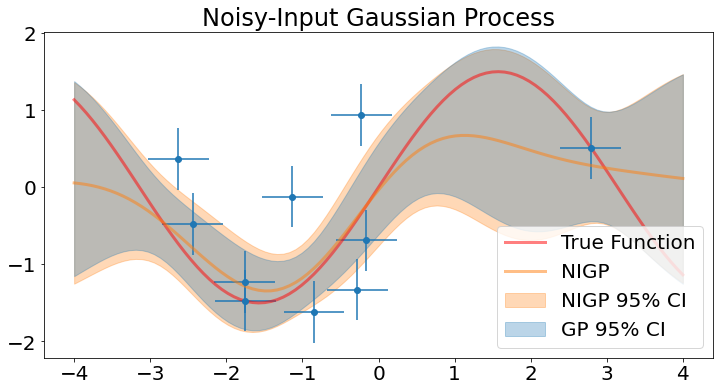

In [25]:
plt.title('Noisy-Input Gaussian Process')

plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')

plt.plot(x_full,f(x_full),color='r',label='True Function',linewidth=3,alpha=0.5)
plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')
plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.legend();

In [26]:
# EIV-GP method
from pyro.infer import MCMC, NUTS, HMC

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1)
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-3), torch.tensor(20.)))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1e-3), torch.tensor(6.)))

#generate a GP gression model conditioned on RSL data
EIV_gpr = PSTHM.GPRegression_EIV(x, y, x_noise**2,RBF_kernel,noise=torch.tensor(y_noise**2),jitter=1e-5)

#use NUTS mcmc to sample the posterior distribution of hyperparameters
#if this is too low, slightly decrease the target_accept_prob and restart again!
mcmc = PSTHM.NUTS_mcmc(EIV_gpr,num_samples=1500,warmup_steps=200,target_accept_prob=0.75)

#predict the mean and variance of GP
EIVGP_mean,EIVGP_cov,EIVGP_sd,likelihood_list = PSTHM.mcmc_predict(EIV_gpr,mcmc,x_full)

Sample: 100%|██████████| 1700/1700 [00:39, 43.39it/s, step size=4.44e-01, acc. prob=0.909]


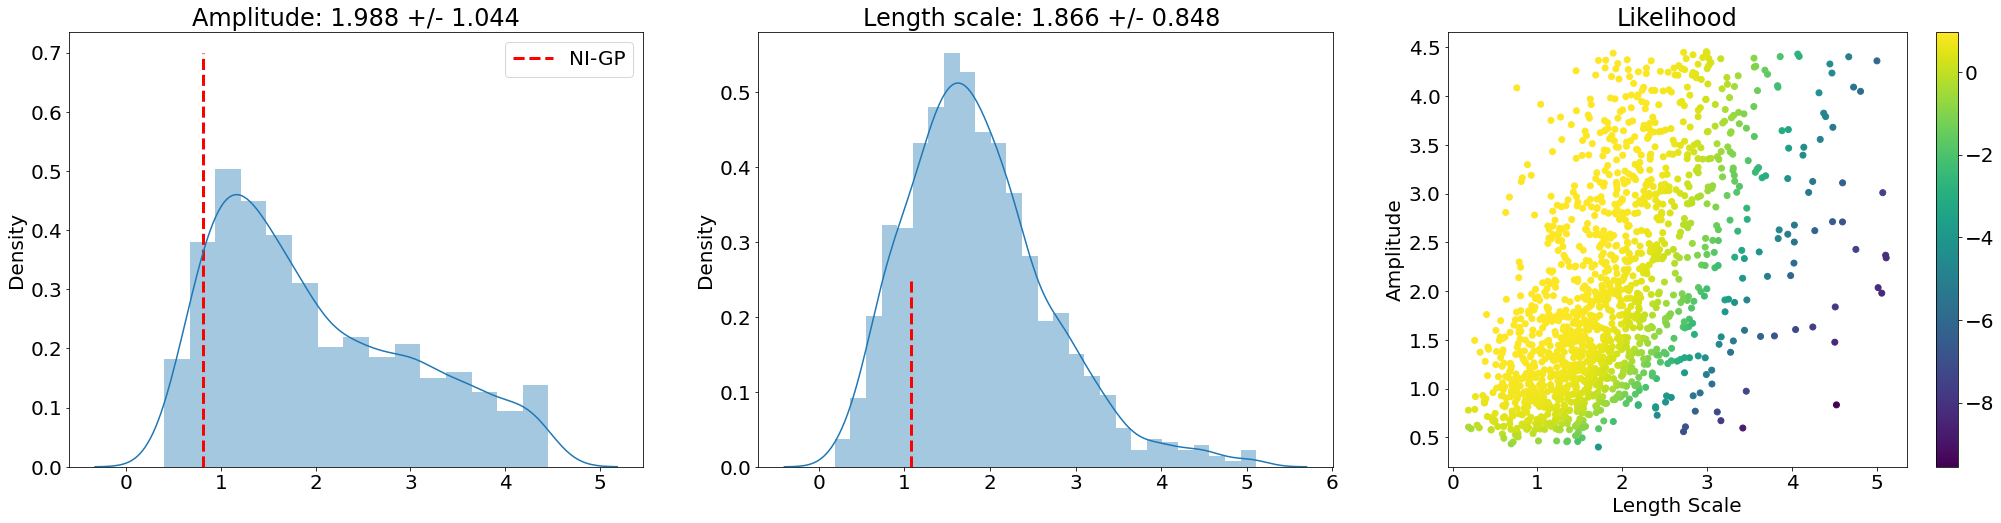

In [27]:
mcmc_variance =mcmc.get_samples()['kernel.variance']
mcmc_lengthscale = mcmc.get_samples()['kernel.lengthscale']

plt.figure(figsize=(35,8))
plt.subplot(131)
sns.distplot(mcmc_variance**0.5)
plt.vlines(NI_gpr.kernel.variance.item()**0.5,0,0.7,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Amplitude: {:5.3f} +/- {:5.3f}'.format(torch.mean(mcmc_variance**0.5),
                                            torch.std(mcmc_variance**0.5)))
plt.legend()
plt.subplot(132)
sns.distplot(mcmc_lengthscale)
plt.vlines(NI_gpr.kernel.lengthscale.item(),0,0.25,color='r',linestyle='--',label='NI-GP',linewidth=3)
plt.title('Length scale: {:5.3f} +/- {:5.3f} '.format(torch.mean(mcmc_lengthscale),
                                                           torch.std(mcmc_lengthscale)))

plt.subplot(133)
plt.title('Likelihood')

plt.scatter(mcmc_lengthscale,mcmc_variance**0.5,c=likelihood_list)
plt.xlabel('Length Scale')
plt.ylabel('Amplitude')
plt.colorbar();

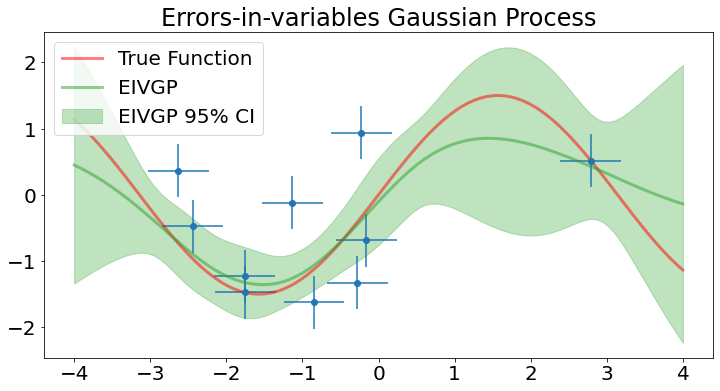

In [28]:
plt.title('Errors-in-variables Gaussian Process')
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0')
plt.plot(x_full,f(x_full),color='r',label='True Function',linewidth=3,alpha=0.5)
plt.plot(x_full,EIVGP_mean,color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.fill_between(x_full,EIVGP_mean-2*EIVGP_sd,EIVGP_mean+2*EIVGP_sd,alpha=0.3,color='C2',label='EIVGP 95% CI')
plt.legend();



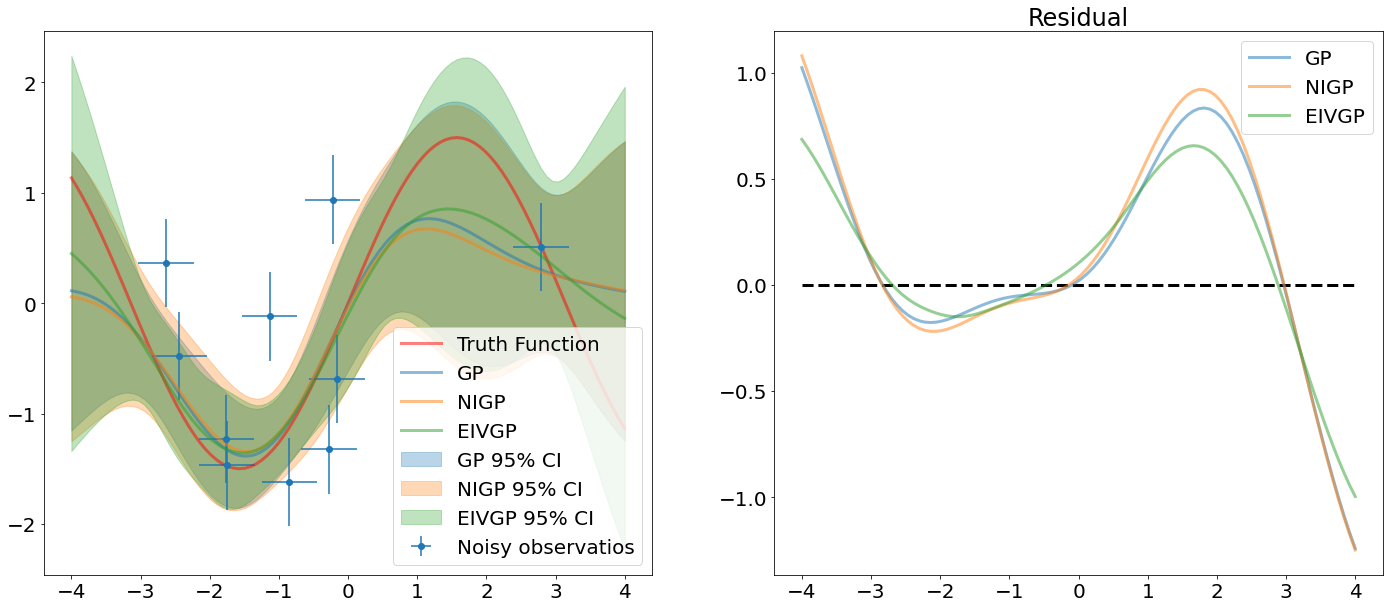

In [29]:
plt.figure(figsize=(24,10))
plt.subplot(121)
plt.errorbar(x_noisy,y_noisy,xerr=x_noise,yerr=y_noise,fmt='o',color='C0',label='Noisy observatios')

plt.plot(x_full,f(x_full),color='r',label='Truth Function',linewidth=3,alpha=0.5)
plt.plot(x_full,GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(x_full,NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(x_full,EIVGP_mean,color='C2',label='EIVGP',linewidth=3,alpha=0.5)

plt.fill_between(x_full,GP_mean.detach().numpy()-2*GP_sd.detach().numpy(),GP_mean.detach().numpy()+2*GP_sd.detach().numpy(),alpha=0.3,color='C0',label='GP 95% CI')
plt.fill_between(x_full,NIGP_mean.detach().numpy()-2*NIGP_sd.detach().numpy(),NIGP_mean.detach().numpy()+2*NIGP_sd.detach().numpy(),alpha=0.3,color='C1',label='NIGP 95% CI')
plt.fill_between(x_full,EIVGP_mean-2*EIVGP_sd,EIVGP_mean+2*EIVGP_sd,alpha=0.3,color='C2',label='EIVGP 95% CI');

plt.legend()

plt.subplot(122)
plt.plot(x_full,f(x_full)-GP_mean.detach().numpy(),color='C0',label='GP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-NIGP_mean.detach().numpy(),color='C1',label='NIGP',linewidth=3,alpha=0.5)
plt.plot(x_full,f(x_full)-EIVGP_mean,color='C2',label='EIVGP',linewidth=3,alpha=0.5)
plt.hlines(0,-4,4,linewidth=3,linestyles='--',color='k')
plt.title('Residual')
plt.legend();

Even observations are still very noisy, three GPs did a great job in recoverying the truth signal! The EIV-GP method seems to show the best performance here. But for more complicated problem, EIV-GP may be very computationally expensive, in that case NI-GP can be a good substitute. 

We have now covered most of commonly-used concept for temporal modelling with GP, so in the next tutorial, we will use what we have learnt to perform temporal GP modelling in New Jersey and Northern North Carolina and compared them with published results. 

Thanks for going through this tutorial, we are actively developing PaleoSTeHM now, so your feedback will be truely valueable to us. You can fill this [survey](https://forms.gle/W1DMPQY8KyAgoT9r6) to let us know what do you think about this tutorial, which will shape the future direction of PaleoSTeHM.